PCA Results:
 [[-2.91961051  3.31268909]
 [-3.78411877 -1.06844051]
 [-2.9654605  -2.16299786]
 [ 9.66918978 -0.08125072]]
Original edges:
 [[ 2  0  0 10]
 [ 5  1  0  0]
 [ 0  0  1  9]]
Normalized edges:
 [[0.17 0.   0.   0.83]
 [0.83 0.17 0.   0.  ]
 [0.   0.   0.1  0.9 ]]
Graph data:
 Data(x=[4, 2], edge_index=[2, 6], y=[4])
Node 1 [-2.92, 3.31]
Node 2 [-3.78, -1.07]
Node 3 [-2.97, -2.16]
Node 4 [9.67, -0.08]

Starting Training...

Epoch 10/100, Loss: 0.6213
Epoch 20/100, Loss: 0.5547
Epoch 30/100, Loss: 0.8406
Epoch 40/100, Loss: 1.0472
Epoch 50/100, Loss: 0.5936
Epoch 60/100, Loss: 0.6391
Epoch 70/100, Loss: 0.9645
Epoch 80/100, Loss: 0.6774
Epoch 90/100, Loss: 0.8122
Epoch 100/100, Loss: 0.7568

Predictions:
 [1 1 0 1]


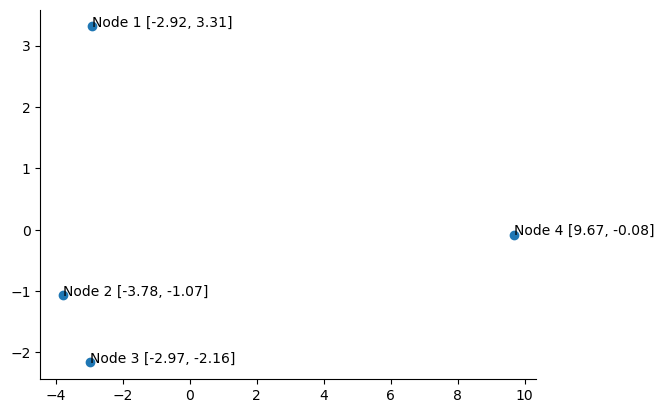

In [1]:
import sys
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from tqdm import tqdm
import random
import scanpy as sc
import seaborn as sns
from torch_geometric.data import Data
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import GraphConv

# 固定随机种子
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# 数据定义
df = np.array([
    [2, 0, 0, 10],
    [5, 1, 0, 0],
    [0, 0, 1, 9],
])

# PCA 降维
pca = PCA(n_components=2).fit_transform(df.T)
print("PCA Results:\n", pca)

# 归一化边权
edges = df
print("Original edges:\n", edges)
edges = edges / (np.sum(edges, axis=1, keepdims=True) + 1e-6)
print("Normalized edges:\n", edges.round(2))

# 使用PyG构建图
row_idx, col_idx = np.nonzero(edges)
edge_index = np.vstack([row_idx, col_idx])

# 节点特征
node_features = torch.tensor(pca, dtype=torch.float)
labels = torch.tensor([-1] * len(pca), dtype=torch.long)  # 假设没有标签信息

# 构建 PyG 数据对象
graph_data = Data(
    x=node_features,
    edge_index=torch.tensor(edge_index, dtype=torch.long),
    y=labels,
)

# 打印图的基本信息
print("Graph data:\n", graph_data)

# 可视化节点
plt.scatter(pca[:, 0], pca[:, 1])
for i in range(len(pca)):
    title = f"Node {i+1} [{pca[i, 0]:.2f}, {pca[i, 1]:.2f}]"
    print(title)
    plt.text(pca[i, 0], pca[i, 1], title)
sns.despine()

# 使用 PyG 训练
class GCN(torch.nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_feats)
        self.conv2 = GraphConv(hidden_feats, out_feats)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# 定义模型、优化器和损失
model = GCN(in_feats=2, hidden_feats=4, out_feats=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

# 示例训练
print("\nStarting Training...\n")
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(graph_data.x, graph_data.edge_index)
    # 使用伪标签训练
    loss = loss_fn(out, torch.randint(0, 2, (len(pca),)))
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# 模型输出和评估
model.eval()
pred = model(graph_data.x, graph_data.edge_index).argmax(dim=1)
print("\nPredictions:\n", pred.numpy())